In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import bayes3d as b
import time
from PIL import Image
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import cv2
import trimesh
import os

In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


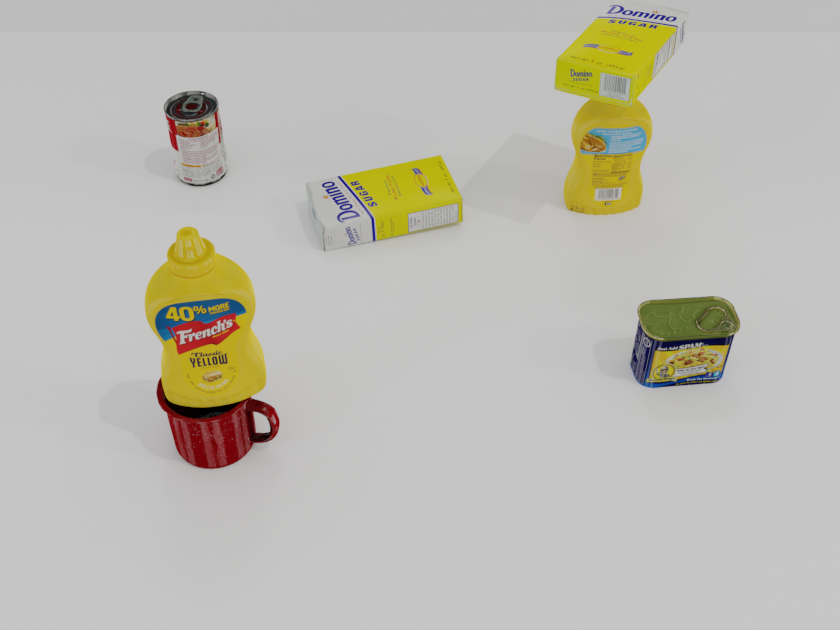

In [3]:
data = np.load("test_scenes/1.npz")
rgb  = jnp.array(data["rgb"])
gt_ids = jnp.array(data["gt_ids"]).astype(jnp.int32)
gt_poses = jnp.array(data["gt_poses"])
gt_poses_offset = jnp.array(data["gt_poses_offset"])
pred_poses_cam_frame = jnp.array(data["pred_poses_cam_frame"])
pred_ids = jnp.array(data["pred_ids"])
intrinsics = data["intrinsics"]
cam_pose_cv2 = jnp.array(data["cam_pose_cv2"])
intrinsics = b.Intrinsics(
    int(intrinsics[0]),
    int(intrinsics[1]),
    intrinsics[2],
    intrinsics[3],
    intrinsics[4],
    intrinsics[5],
    intrinsics[6],
    intrinsics[7],
)
rgb_viz = b.get_rgb_image(rgb)
rgb_viz

In [4]:
b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)
b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=jnp.array([2.0, 2.0, 0.02]))

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (864, 640, 1024)


In [5]:
poses = jnp.concatenate([pred_poses_cam_frame, b.transform_from_pos(jnp.array([0.0, 0.0, -0.1]))[None,...] ])
ids = jnp.concatenate([pred_ids, jnp.array([21])])
b.clear()
colors = b.distinct_colors(len(poses))
for i in range(len(poses)):
    b.show_trimesh(f"{i}", b.RENDERER.meshes[ids[i]],color=colors[i])
    b.set_pose(f"{i}", poses[i])

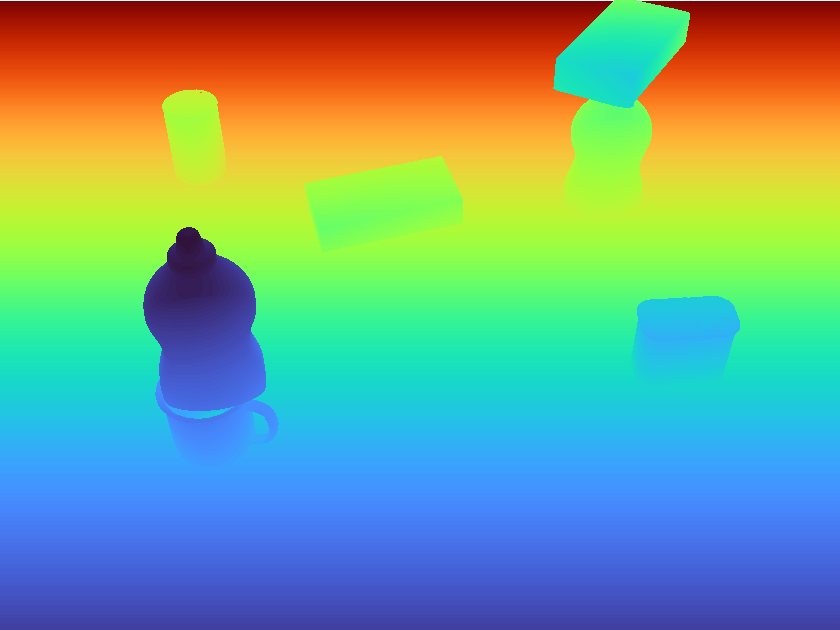

In [6]:
img = b.RENDERER.render(b.inverse_pose(cam_pose_cv2) @ poses, ids)
depth = b.get_depth_image(img[...,2])
depth

In [7]:
def get_approximating_contact(object_idx_1, object_idx_2, face_1,face_2):
    contact_params ,slack = b.scene_graph.closest_approximate_contact_params(
        poses[object_idx_1] @ b.scene_graph.get_contact_planes(b.RENDERER.model_box_dims[ids[object_idx_1]])[face_1],
        poses[object_idx_2] @ b.scene_graph.get_contact_planes(b.RENDERER.model_box_dims[ids[object_idx_2]])[face_2]
    )
    dimensions_on_contact_plane = b.scene_graph.get_contact_plane_dimenions(b.RENDERER.model_box_dims[ids[object_idx_1]])[face_1]
    valid = (object_idx_1!=object_idx_2) * jnp.all(jnp.abs(contact_params[:2]) < (dimensions_on_contact_plane / 2.0))
    return jax.lax.select(valid, contact_params , jnp.full((3,), jnp.inf)) , jax.lax.select(valid, slack, jnp.full((4,4), jnp.inf))
get_approximating_contact_vmap = jax.jit(b.multivmap(get_approximating_contact))


inferred_contact_params, slacks = get_approximating_contact_vmap(jnp.arange(len(poses)), jnp.arange(len(poses)), jnp.arange(6), jnp.arange(6))
print(inferred_contact_params.shape)
print(slacks.shape)

(8, 8, 6, 6, 3)
(8, 8, 6, 6, 4, 4)


In [8]:

position_errors = jnp.abs(slacks[...,:3,3]).sum(-1)

from jax.scipy.spatial.transform import Rotation
rotation_matrix_to_angle_error = lambda pose : jnp.linalg.norm(Rotation.from_matrix(pose[:3,:3]).as_rotvec())

angle_errors = jnp.vectorize(rotation_matrix_to_angle_error, signature="(3,3)->()")(slacks[...,:3,:3])
assert position_errors.shape == angle_errors.shape

In [10]:
NAMES = np.concatenate([b.utils.ycb_loader.MODEL_NAMES, np.array(["TABLE"])])
TABLE_IDX = len(poses) - 1
root_poses = poses
box_dims = b.RENDERER.model_box_dims[ids]
parents = jnp.full((len(poses),), -1)
node_names = NAMES[ids]
contact_params = jnp.full((len(poses),3), 0.0)
face_parents = jnp.full((len(poses),), -1)
face_children = jnp.full((len(poses),), -1)
sg = b.scene_graph.SceneGraph(root_poses, box_dims, parents, contact_params, face_parents, face_children)
sg.visualize("test.png", node_names=node_names)

In [11]:
sort_order = jnp.argsort(position_errors[TABLE_IDX].reshape(-1))
for i in sort_order:
    (child_idx, face_1, face_2) = jnp.unravel_index(i, position_errors[TABLE_IDX].shape)
    if jnp.all(parents[child_idx] != -1):
        continue
    print(position_errors[TABLE_IDX, child_idx, face_1, face_2], angle_errors[TABLE_IDX, child_idx, face_1, face_2])
    if position_errors[TABLE_IDX, child_idx, face_1, face_2] < 0.01 and angle_errors[TABLE_IDX, child_idx, face_1, face_2] < 0.03:
        parents = parents.at[child_idx].set(TABLE_IDX)
        face_parents = face_parents.at[child_idx].set(face_1)
        face_children = face_children.at[child_idx].set(face_2)
        contact_params = contact_params.at[child_idx].set(inferred_contact_params[TABLE_IDX, child_idx, face_1, face_2])
    else:
        break

0.0030130446 0.027115045
0.004922002 0.02743829
0.0054349895 0.007191823
0.007636547 0.017004529
0.008724064 0.010002548
0.086491466 0.010715185


In [12]:
sort_order = jnp.argsort(position_errors.reshape(-1))
for i in sort_order:
    (parent_idx, child_idx, face_1, face_2) = jnp.unravel_index(i, position_errors.shape)
    if jnp.all(parents[child_idx] != -1):
        continue
    print(position_errors[parent_idx, child_idx, face_1, face_2], angle_errors[parent_idx, child_idx, face_1, face_2])
    if position_errors[parent_idx, child_idx, face_1, face_2] < 0.01 and angle_errors[parent_idx, child_idx, face_1, face_2] < 0.09:
        parents = parents.at[child_idx].set(parent_idx)
        face_parents = face_parents.at[child_idx].set(face_1)
        face_children = face_children.at[child_idx].set(face_2)
        contact_params = contact_params.at[child_idx].set(inferred_contact_params[parent_idx, child_idx, face_1, face_2])
    else:
        break

0.009593124 0.031021805
0.009633777 0.014267166
inf nan


In [13]:
sg = b.scene_graph.SceneGraph(root_poses, box_dims, parents, contact_params, face_parents, face_children)
sg.visualize("test.png", node_names=node_names)

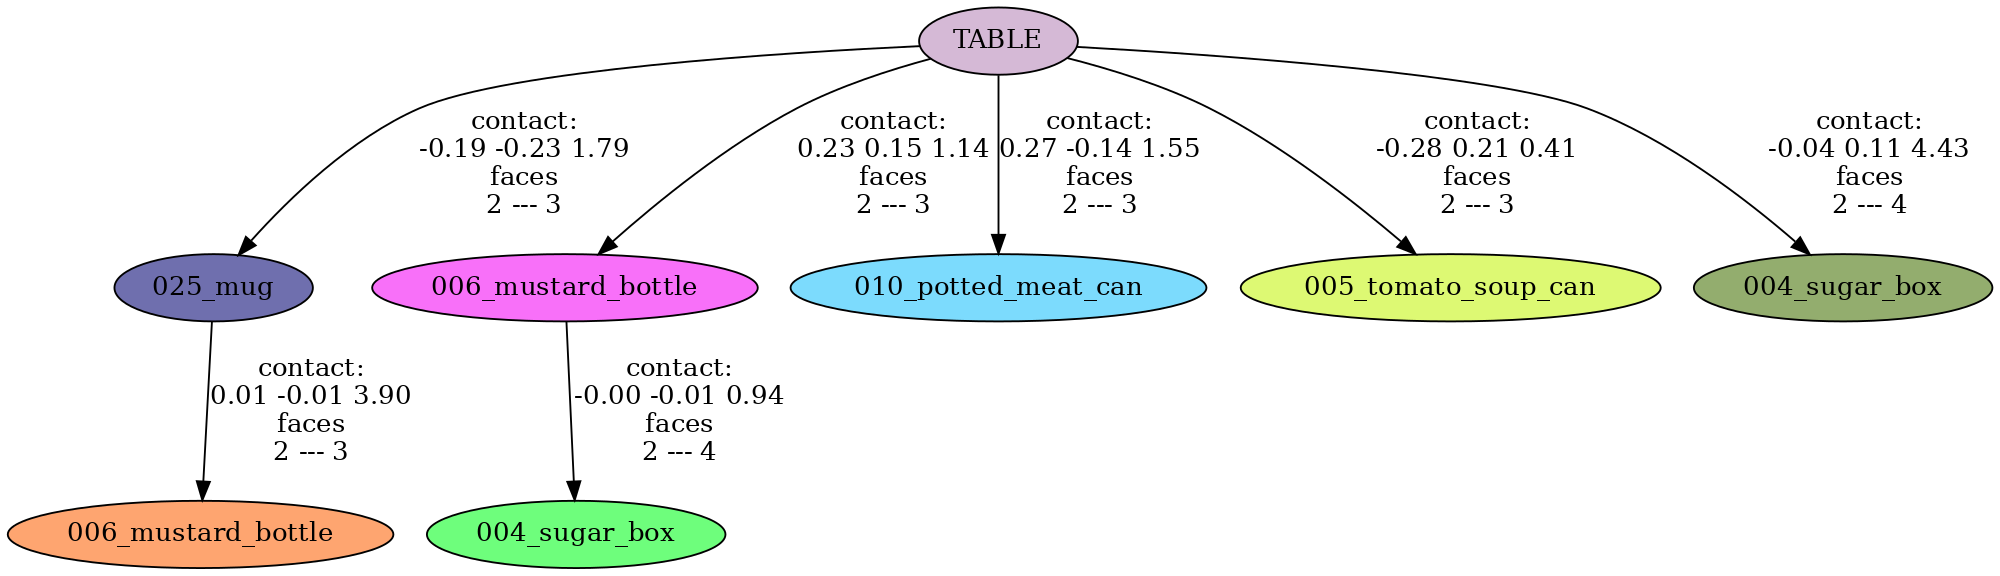

In [14]:
b.viz.load_image_from_file("test.png")

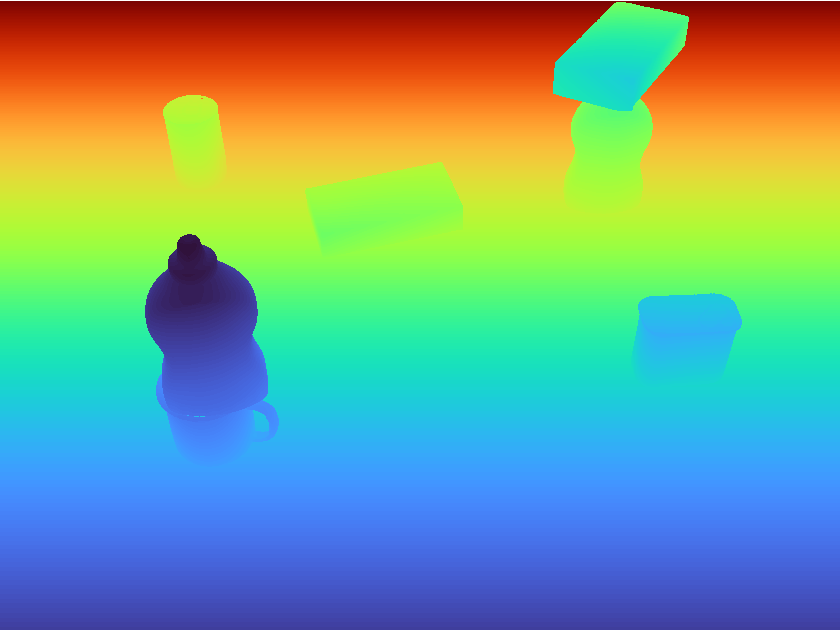

In [15]:
sg_poses = sg.get_poses()
img = b.RENDERER.render(b.inverse_pose(cam_pose_cv2) @ sg_poses, ids)
depth = b.get_depth_image(img[...,2])
depth